## EKF Localisation using UTIAS dataset with known correlation

### Effect of Model change on filter 

This notebook explores the impact of model change on filter performance; Previous model by Andrew Kramer
seemed to overfit the problem in hand with process noise parameters tuned to achieve better performance.

So, in this notebook, the EKF model and noise parameters are changed to standard differential models and filter performance is analysed

### Importing packages and other helper files

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

import helper_functions as help_fns
import EKF_helper_functions as EKF
from motion_models import diff_drive_motion_model as fk
from measurement_models import lidar_2d_model as hk
from plot_functions import plot_cov_ellipse

from IPython import display

### Load and resample raw data from UTIAS data set, reading Matlab reference output

In [2]:
#sample time of the simulation
deltaT = 0.02; 

#from Andre Kramer's script
r_robot = 0.165;
r_landmark = 0.055;


#The robot's position groundtruth, odometry, and measurements are stored in Robots
Barcodes, Landmark_Groundtruth, Robots = help_fns.load_MRCLAM_dataSet();
Barcodes = Barcodes.astype(int)
codedict = dict(np.column_stack((Barcodes[:,1], Barcodes[:,0])))
Robots, timesteps = help_fns.sample_MRCLAM_dataSet(Robots, deltaT)

matlab_op_file = '../localization/test.dat'
try:
    matlab_op_data = np.loadtxt(matlab_op_file)
    print('Loaded matlab reference output')
except:
    print('Cannot Load matlab reference output')

Loading data
Reading robot1_Groundtruth data
Reading robot1_odometry data
Reading robot1_measurements data
Robot1 data read successfully
------------------------------------------------
All data successfully read
------------------------------------------------
Sampled data successfully
-------------------------
Loaded matlab reference output


### Defining the motion, measurement models and the necessary jacobians

In [3]:
#to include images of the models and jacobians to be used in the filter

### Defining constants for the filter

In [4]:
#for now assumed the measurement noise and initial uncertainty are known, process noise is the only unknown
sigma_range   = 2
sigma_bearing = 3
sigma_id      = 1

#very small as we're starting from the GT data
initial_measurement_variance = 0.01  


def compute_noise_matrices(params):
    """"
    Given the std dev of wheel odometry sensors and lidar measurements
    returns the variance matrices
    """
    M = np.array([
            [params[0]**2, 0],
            [0, params[1]**2]
            ])

    R = np.array([
            [sigma_range**2, 0, 0],
            [0, sigma_bearing**2, 0],
            [0, 0, sigma_id**2]
            ])
    return M, R

### Initialise estimated parameters to zeros

In [5]:
def initialise_filter(Robots, robot_num, start, params):

    # set start time
    t = Robots[str(robot_num)]['G'][start, 0]

    # set starting pose mean to pose groundtruth at start time
    poseMean = Robots[str(robot_num)]['G'][start,1:4].reshape(3,1)
    #poseCov = np.eye(3) *  params['initial_measurement_variance']
    poseCov = np.eye(3) *  initial_measurement_variance

    #tracks which measurement is next received
    #iterating to measurement index which time corresponds to 
    measurementIndex = 0;

    #advance measurement index until the next measurement time is greater than the starting time
    while (Robots[str(robot_num)]['M'][measurementIndex, 0] < (t - 0.05)):
            measurementIndex = measurementIndex + 1;
            
    return poseMean, poseCov, measurementIndex

### Run filter for input Odometry and Lidar data

In [6]:
#loop through all odometry and measurement samples
#updating the robot's pose estimate with each step
#reference table 7.2 in Probabilistic Robotics

# start index default is set to 600 because earlier data was found to cause problems
def run_filter(Robots, params, robot_num =1, start = 600):
    poseMean, poseCov, measurementIndex = initialise_filter(Robots, robot_num, start, params)
    M,R = compute_noise_matrices(params)
    tgt_bot = Robots[str(robot_num)]
    N_timesteps = tgt_bot['G'].shape[0]

    # initialize time, and pose estimate
    filter_op = {}
    filter_op['Est'] = np.zeros((N_timesteps, 4))
    filter_op['Est_var'] = np.zeros((N_timesteps, 3, 3))

    
    for i in range(start, tgt_bot['G'].shape[0]):

        #update time
        t = tgt_bot['G'][i,0]

        """ #######   Prediction step     #######   """    
        #wrap to pi
        poseMean[2, 0] =  help_fns.conBear(poseMean[2,0])
        u_t  = np.array([tgt_bot['O'][i,1], tgt_bot['O'][i,2]])   
        
        poseMeanBar, poseCovBar = EKF.ekf_predict_step(poseMean, poseCov, u_t, fk, M, deltaT)
        poseMeanBar[2, 0] =  help_fns.conBear(poseMeanBar[2,0])

        #get measurements for the current timestep, if any exist
        z, measurementIndex = help_fns.getObservations(Robots, robot_num, t, measurementIndex, codedict)
        
        #if any measurements are available
        if z[2,0] > 1:
            for k in range(0, z.shape[1]): #loop over every measurement
                """ #######   Measurement update step     #######   """    
                j = int(z[2,k]);            
                l_data = np.array([Landmark_Groundtruth[j-1, 1], Landmark_Groundtruth[j-1, 2], j])
                zk = z[:,k].reshape(3,1)
                poseMeanBar,poseCovBar = EKF.ekf_update_step(poseMeanBar,poseCovBar, zk, hk, l_data, R, deltaT)
                poseMeanBar[2, 0] =  help_fns.conBear(poseMeanBar[2,0])

        #update pose mean and covariance; add constraints heading to between 0 and 2*pi
        poseMean = poseMeanBar;
        poseMean[2] = help_fns.conBear(poseMean[2]);
        poseCov = poseCovBar;

        #add pose mean to estimated position vector
        filter_op['Est'][i,:] = np.array([t, poseMean[0], poseMean[1], poseMean[2]])
        filter_op['Est_var'][i,:] = poseCov
    return filter_op

In [7]:
""" ## process noise parameters found by manual Grid searching and other algorithms; need to be improved """
#odometry reading noise parameters of format ['sigma_v_t', sigma_omega_t]
noise_params    = [1.05, 0.18]

In [8]:
#remember python indexing starts t 0, whereas matlab starts with 1
EKF_batch_filter = run_filter(Robots, noise_params, start = 600)

### RMSE Error as loss function

In [9]:
gt_pose  = Robots['1']['G'][:,1:]
est_pose = EKF_batch_filter['Est'][:,1:]

ekf_filter_loss    = help_fns.path_loss2(gt_pose, est_pose, 600, include_theta=True)
matlab_ref_op_loss =  help_fns.path_loss2(gt_pose, matlab_op_data[:,1:], 600, include_theta=True)

print('EKF estimated OP total deviation is ' + str(ekf_filter_loss))
print('Matlab ref    OP total deviation is ' + str(matlab_ref_op_loss))

EKF estimated OP total deviation is 144521.45436134932
Matlab ref    OP total deviation is 135818.1469195331


In [10]:
def run_filter_params(Robots, params, start=600):
    batch_filter = run_filter(Robots, params, start = 600)
    est_pose     = batch_filter['Est'][:,1:]
    filter_loss  = help_fns.path_loss2(gt_pose, est_pose, 600, include_theta=True)
    #print('Batch_filter OP total deviation is ' + str(filter_loss))
    return batch_filter, filter_loss

In [11]:
%%time
temp, err = run_filter_params(Robots, noise_params, 600)

CPU times: user 5.08 s, sys: 11.7 ms, total: 5.09 s
Wall time: 4.57 s


### Manual Grid search code

### Sample results by manual gird search

### Twiddle algorithm 

In [12]:
noise_params

[1.05, 0.18]

### Set plotting parameters for visualising output

In [13]:
plot_start_index = 600
plot_stop_index  = 20000
plot_refresh_rate = 5.0 #time in seoconds

In [14]:
def plot_results(Robots, filter_op, start, stop, refresh_rate):
    step_size = int(refresh_rate / deltaT)
    xmin, xmax = Robots['1']['G'][:,1].min(), Robots['1']['G'][:,1].max()
    ymin, ymax = Robots['1']['G'][:,2].min(), Robots['1']['G'][:,2].max()

    plt.figure(figsize=(18,12))
    plt.axis('equal')
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.grid(True)   

    for i in range(start, stop, step_size):
        plt.clf()            
        plt.plot(Landmark_Groundtruth[:,1], Landmark_Groundtruth[:,2], 'co', label = 'Landmarks')

        x,y,theta = Robots['1']['G'][i,1], Robots['1']['G'][i,2], Robots['1']['G'][i,3]
        dx, dy = (r_robot + 0.05) * np.cos(theta), (r_robot + 0.05) * np.sin(theta) 
        plt.plot(x, y, 'go', label = 'GT_pose')
        plt.arrow(x,y,dx,dy)

        #plot_robot_pose(EKF_batch_filter['Est'][i,1:], EKF_batch_filter['Est_var'][i], 'Est pose', plot_var = True)
        poseMean = filter_op['Est'][i,1:]
        posecov  = filter_op['Est_var'][i][0:2, 0:2]
        ex,ey,etheta = poseMean[0], poseMean[1], poseMean[2]
        dex, dey = (r_robot + 0.05) * np.cos(etheta), (r_robot + 0.05) * np.sin(etheta) 
        plt.plot(ex,ey, 'rx', label = 'Est_pose')
        plt.arrow(ex,ey,dex,dey)
        plot_cov_ellipse(posecov, poseMean[0:2].reshape(2,1), nstd=1, alpha=0.25, color='green')
        
        mx,my,mtheta = matlab_op_data[i,1], matlab_op_data[i,2], matlab_op_data[i,3]
        dmx, dmy = (r_robot + 0.05) * np.cos(mtheta), (r_robot + 0.05) * np.sin(mtheta) 
        plt.plot(mx,my, 'gx', label = 'matlab_output')
        plt.arrow(mx,my,dmx,dmy)

        plt.legend()
        display.display(plt.gcf())
        display.clear_output(wait=True)
    return None

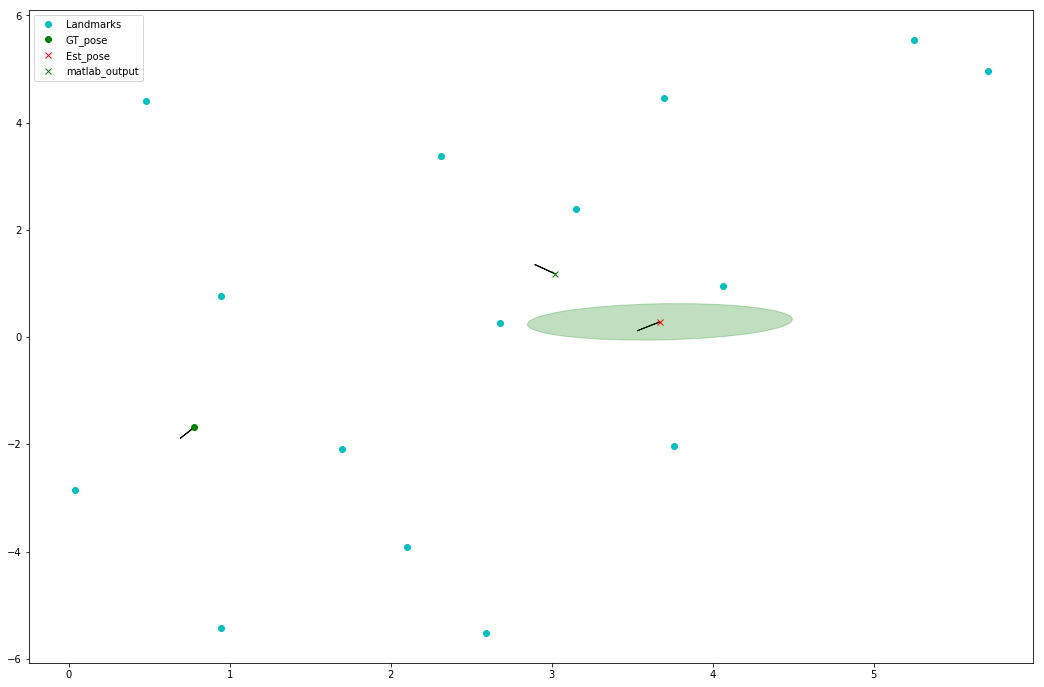

In [15]:
t = plot_results(Robots, EKF_batch_filter, plot_start_index, plot_stop_index, plot_refresh_rate)

### Futher work to be done

Parameter search by Grids and Twiddle algorithm are very general algorithms; They are not specialised at
tuning noise parameters for filters So further work will be:

1. UKF Implementation and check its performance with same parameters
2. Establishing a standard method to find noise parameters for such problems